# Import dataset

In [1]:
# Reading in Multi-file netCDF impossible as file format is not accepted

import os
import pandas as pd
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

full_dataset = dict(time=[], cereal=[], nc=[])
path = 'data/raw'
with os.scandir(path) as dir_data:
    for sub_dir_data in dir_data:
        for f in os.scandir(os.path.join(path, sub_dir_data.name)):
            path_f = os.path.join(path, sub_dir_data.name, f.name)
            time = int(f.name.split('_')[1][:4])
            full_dataset['time'].append(time)
            full_dataset['cereal'].append(sub_dir_data.name)
            full_dataset['nc'].append(nc.Dataset(path_f, 'r'))


df = pd.DataFrame(full_dataset)

# Check data

The dataset spans from years 1981 to 2016

--------------------

The various types of cereals: 
['maize_second' 'wheat_spring' 'maize' 'rice_major' 'rice' 'maize_major'
 'wheat' 'soybean' 'rice_second' 'wheat_winter']

--------------------


Variable informations:

{'lon': <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    units: degrees_east
    long_name: Longitude
unlimited dimensions: 
current shape = (720,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'lat': <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    units: degrees_north
    long_name: Latitude
unlimited dimensions: 
current shape = (360,)
filling on, default _FillValue of 9.969209968386869e+36 used, 'var': <class 'netCDF4._netCDF4.Variable'>
float32 var(lat, lon)
    _FillValue: -999000000.0
unlimited dimensions: 
current shape = (360, 720)
filling on}

--------------------


Dimension informations:

{'lon': <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 720, 'lat': <class 'netCDF4

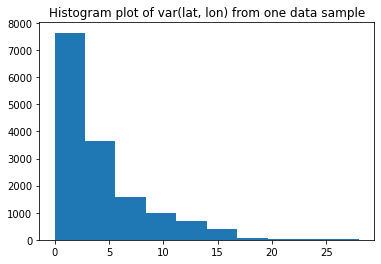

In [2]:
# Checking no data is missing
df.isna().any()

# We keep in mind that data are missing in year 1981 and 2016.
# However, it is not specified where in the data. 
# So we assume that the aforementioned years are just innacurate.

# Year span
print(f"The dataset spans from years {df['time'].min()} to {df['time'].max()}")
print('\n--------------------\n')

# Different types of cereals
print(f"The various types of cereals: \n{df['cereal'].unique()}")
print('\n--------------------\n')


# Variables inside nc4 files
print('\nVariable informations:\n')
print(df['nc'][0].variables)
print('\n--------------------\n')


# fill value = -999000000.0 for var(lat, lon)

# Dimensions inside nc4 files
print('\nDimension informations:\n')
print(df['nc'][0].dimensions)
print('\n--------------------\n')


# Basic stats on var(lat, lon) 
print("Basic stats on var(lat, lon) for one data sample")
var_example = df['nc'][100]['var'][:]

# Get min/max
print(f'\nmin value: {var_example.compressed().min()} (without invalid data)\n')
print(f'max value: {var_example.compressed().max()}\n')


# Get percent of valid values
percent_valid = 100 * var_example.count() / np.prod(var_example.data.shape)
print(f'Percent of valid values: {percent_valid}')
print('\n--------------------\n')


# Histogram plot of var(lat, lon) from a data sample
plt.hist(var_example.compressed());
plt.title('Histogram plot of var(lat, lon) from one data sample')
plt.xlabel = 'Value  bins'
plt.ylabel = 'count'

In [3]:
# Dataset preprocessing

# Sort data as they are messy when load with scandir
df = df.sort_values(['cereal', 'time'], ignore_index=True) # sorting by time

# Add a 'yield' column for display purpose
# Remask with -1/0 to avoid flatten amplitude
mask_value = 0
list_var = []
for row in df['nc']:
    row_tmp = row['var'][:]
    row_tmp.set_fill_value(-mask_value)
    mask = row_tmp.mask
    list_var.append(np.ma.masked_array(row_tmp.filled(fill_value=-mask_value), mask))
df['yield_map'] = list_var


df['yield_mean'] = df['yield_map'].apply(lambda row: row.data.mean())
df_by_cereal = df.groupby(['cereal'])

df.drop('nc', axis='columns', inplace=True)

df.head()

,time,cereal,yield_map,yield_mean
0,1981,maize,"[[--, --, --, --, --, --, --, --, --, --, --, ...",0.048321
1,1982,maize,"[[--, --, --, --, --, --, --, --, --, --, --, ...",0.163388
2,1983,maize,"[[--, --, --, --, --, --, --, --, --, --, --, ...",0.146958
3,1984,maize,"[[--, --, --, --, --, --, --, --, --, --, --, ...",0.161963
4,1985,maize,"[[--, --, --, --, --, --, --, --, --, --, --, ...",0.169750


# Plot yield map

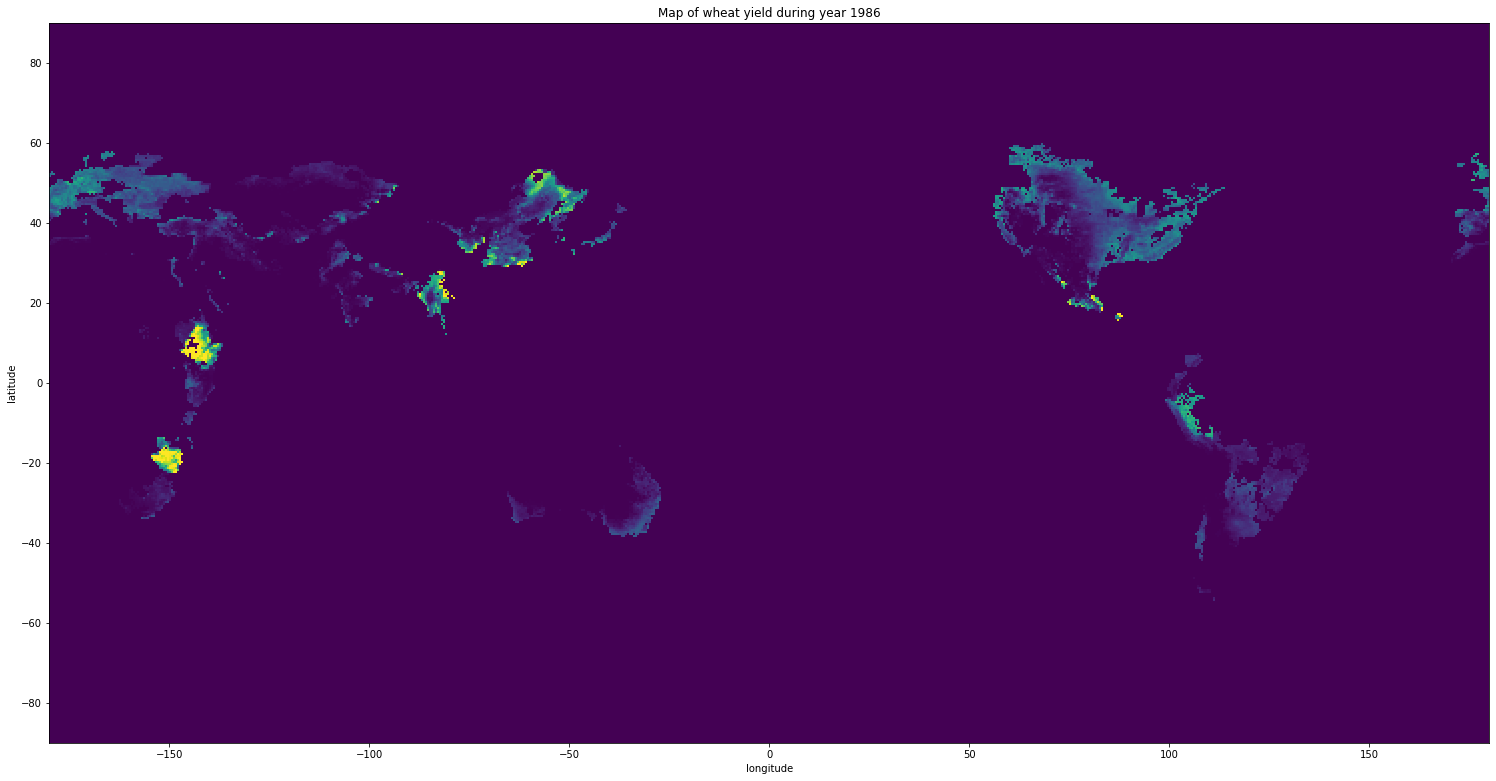

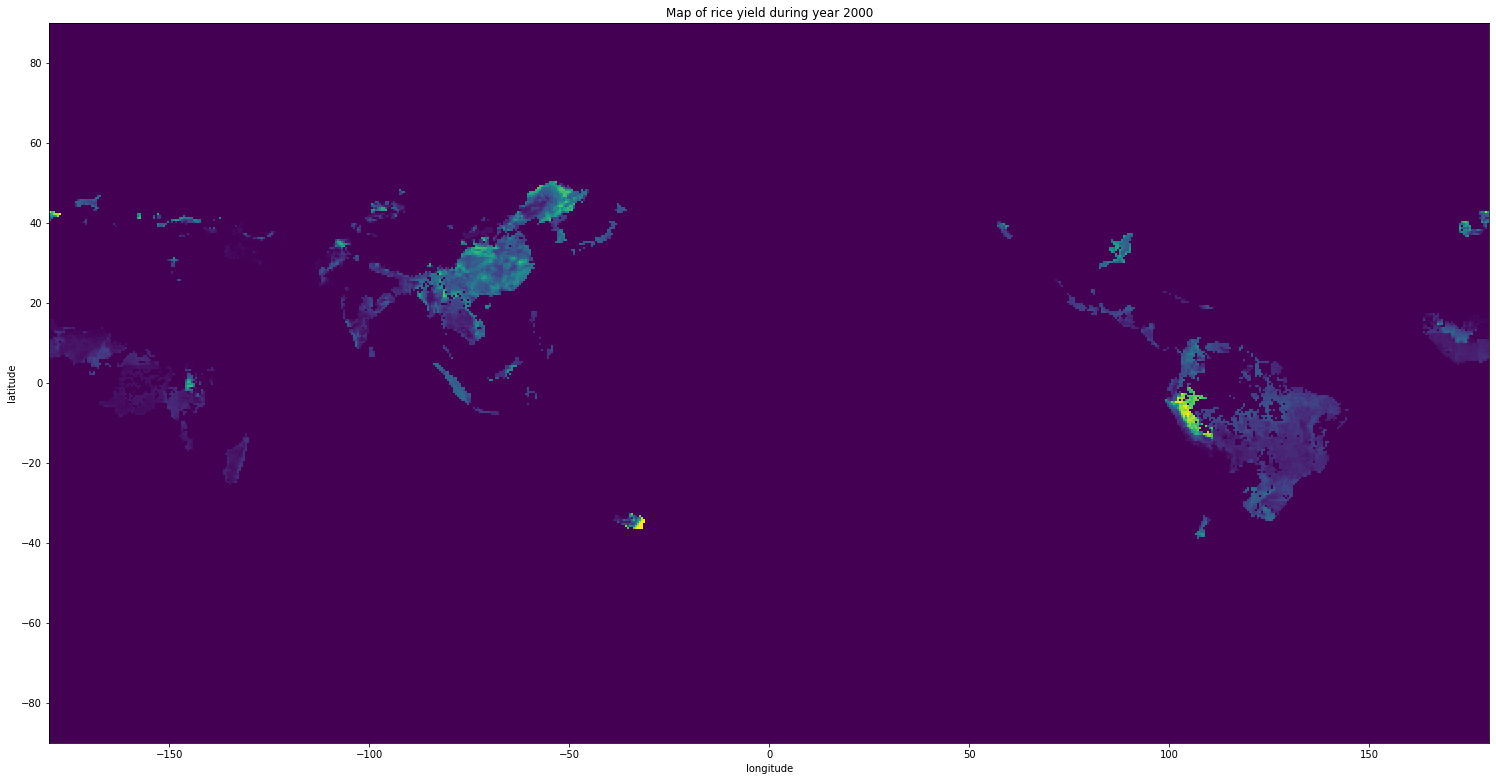

In [4]:
def plot_yield_map(df, cereal=[], time=[]):
    if (cereal and time):
        var = df[(df['cereal'] == cereal) & (df['time'] == time)]['yield_map'].iat[0].data[::-1, :]
    else:
        var = df[::-1, :]
        cereal = ''
        time = ''
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')
    ax.set_title(f'Map of {cereal} yield during year {time}')
    ax.imshow(var, extent=[-180, 180, -90, 90])
    
    
plot_yield_map(df, cereal='wheat', time=1986)
plot_yield_map(df, cereal='rice', time=2000)

# Some possible analysis

## Global

### Evolution of mean yield averaged across all the cereal along time axis

In general, the crops amount increases until 2009


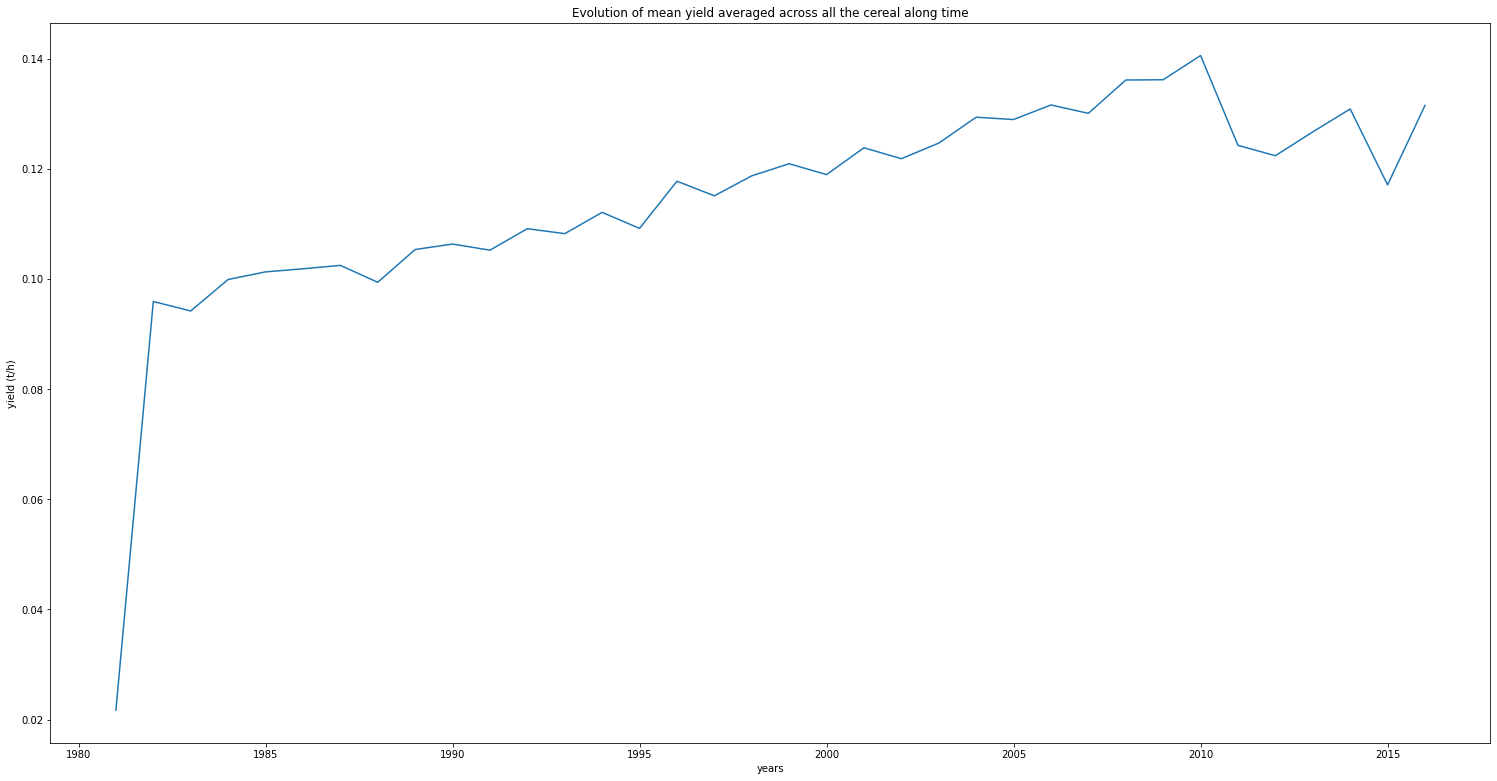

In [5]:
cereal_trend = df.groupby(['time']).agg({'time': 'first', 'yield_mean': 'mean'})

fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
ax.plot(cereal_trend['time'], cereal_trend['yield_mean'])
ax.set_xlabel('years')
ax.set_ylabel('yield (t/h)')
ax.set_title('Evolution of mean yield averaged across all the cereal along time')

print('In general, the crops amount increases until 2009')

### Evolution of mean yield averaged across all years for each cereal type

                    cereal  yield_mean
cereal                                
maize                maize    0.204655
maize_major    maize_major    0.204232
maize_second  maize_second    0.020351
rice                  rice    0.149929
rice_major      rice_major    0.148148
rice_second    rice_second    0.028991
soybean            soybean    0.048348
wheat                wheat    0.163406
wheat_spring  wheat_spring    0.070507
wheat_winter  wheat_winter    0.105697
The maize produces the most while maize during secondary season produces the less. Wheat is more constant between seasons.


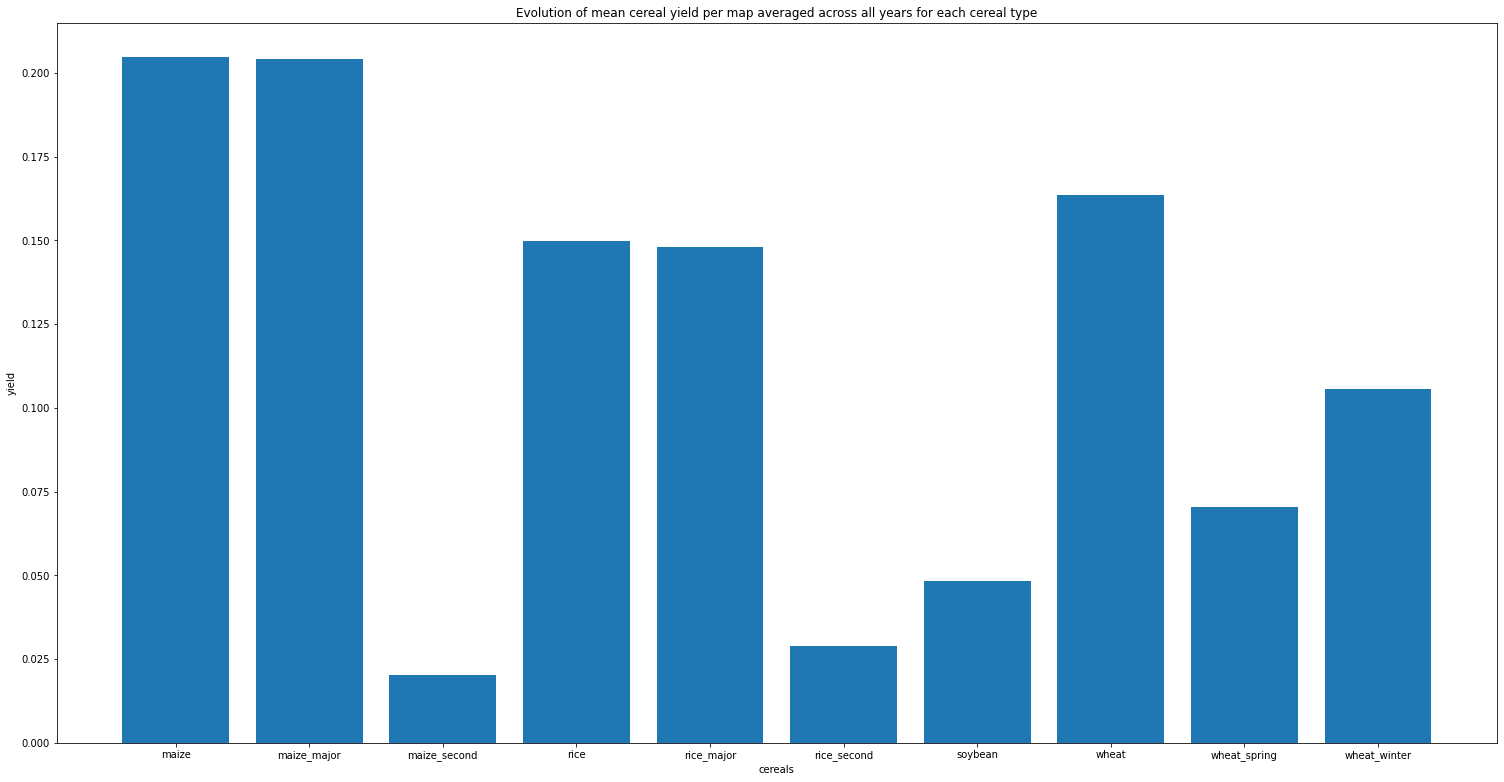

In [6]:
cereal_type = df.groupby(['cereal']).agg({'cereal': 'first', 'yield_mean': 'mean'})
print(cereal_type)


fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
#plt.bar(cereal_label, cereal_value);
plt.bar(cereal_type['cereal'], cereal_type['yield_mean'])
ax.set_xlabel('cereals')
ax.set_ylabel('yield')
ax.set_title('Evolution of mean cereal yield per map averaged across all years for each cereal type')

print('The maize produces the most while maize during secondary season produces the less. Wheat is more constant between seasons.')

### Evolution of mean yield for each cereal type along time axis


All cereals follow more or less the same trend.



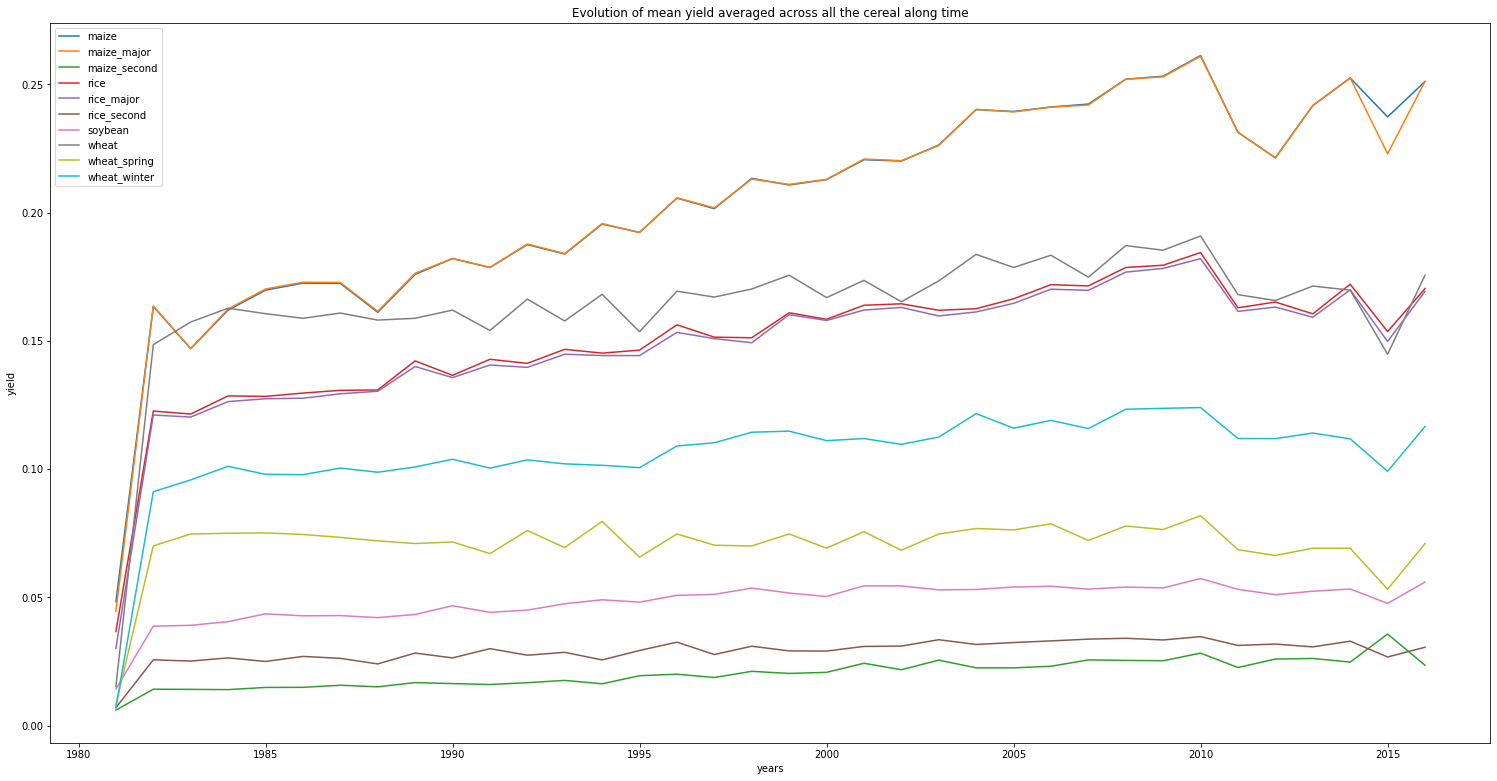

In [7]:
df_by_cereal = df.groupby(['cereal'])
cereal_type_trend = df_by_cereal.apply(
    lambda grp: [row for row in grp['yield_mean']]
)


fig = plt.figure(figsize=(20,10))
ax = fig.add_axes([0,0,1,1])
legend = []
time = df['time'].unique()
for cereal_name, cereal_list in cereal_type_trend.items():
    plt.plot(time, cereal_list)
    legend.append(cereal_name)
ax.legend(legend)
ax.set_xlabel('years')
ax.set_ylabel('yield')
ax.set_title('Evolution of mean yield averaged across all the cereal along time')

comment = '''
All cereals follow more or less the same trend.
'''
print(comment)

### Map of average cereal yield over all the cereals and all the years

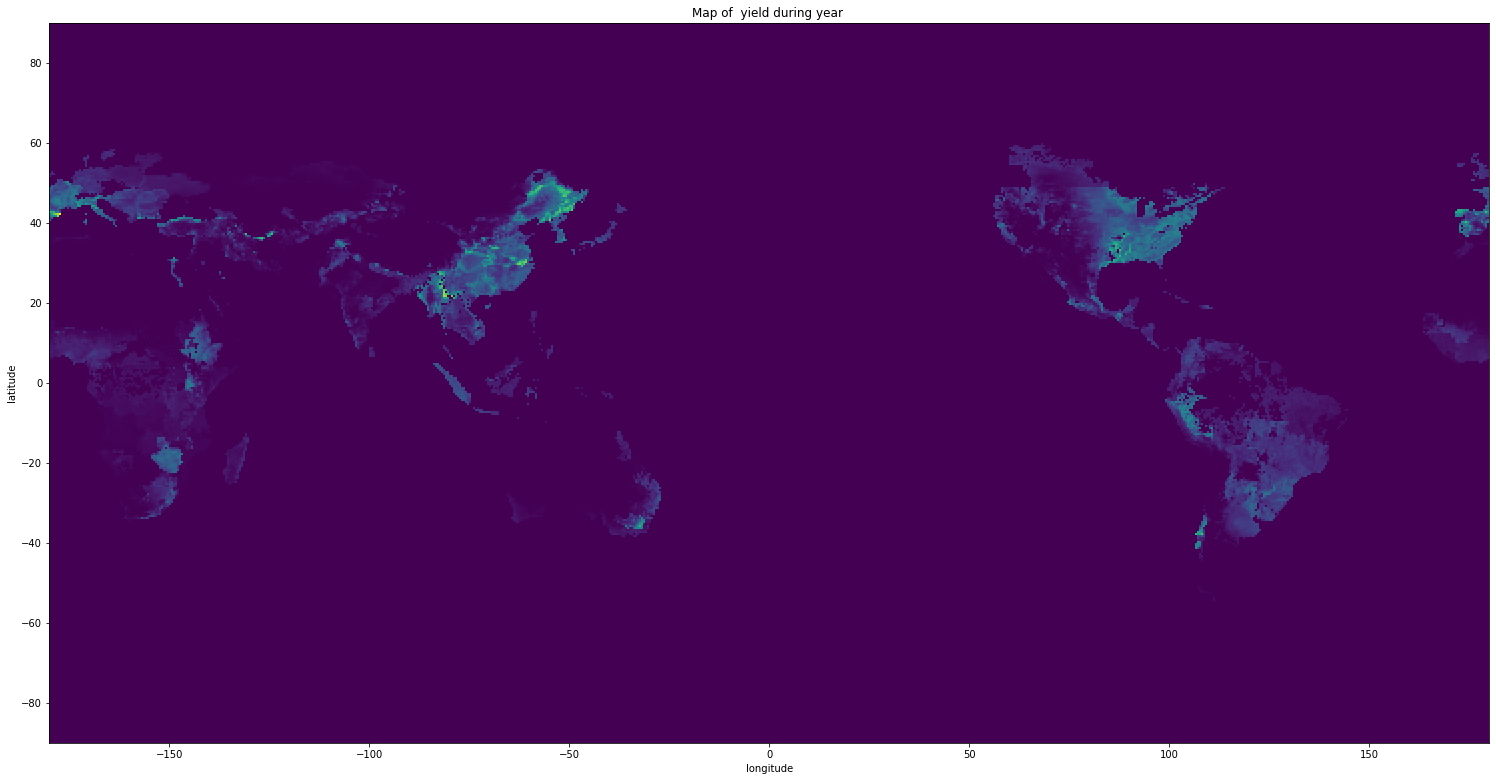

In [8]:
plot_yield_map(df['yield_map'].apply(lambda var: var.data).mean())

# Prediction

## ARIMA Model

In [9]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset_list, p_values, d_values, q_values):
    best = {}
    best['score'] = []
    best['cfg'] = []
    for i, dataset in enumerate(dataset_list):
        print(f'dataset {i}')
        dataset = dataset.astype('float32')
        best_score, best_cfg = float("inf"), None
        for p in p_values:
            for d in d_values:
                for q in q_values:
                    order = (p,d,q)
                    try:
                        mse = evaluate_arima_model(dataset, order)
                        if mse < best_score:
                            best_score, best_cfg = mse, order

                            print('ARIMA%s MSE=%.5f' % (order,mse))
                    except:
                        continue
    best['score'].append(best_score)
    best['cfg'].append(best_cfg)
    mean_best_score = pd.DataFrame(best).groupby('cfg', as_index=False).agg({'score':'mean', 'cfg': 'first'}).min()
    print(f'Best ARIMA%s MSE={mean_best_score["score"]:5f}, model parameters: {str(mean_best_score["cfg"])}')

In [10]:
# Grid search of ARIMA model to get best parameters

series = np.array([row[1] for row in df_by_cereal['yield_mean']])

p_values = [1, 2, 3]
d_values = range(0, 2)
q_values = range(0, 3)

warnings.filterwarnings("ignore")

# Evaluate ARIMA model over all cereal map mean value time series
# We compute the mean over all MSE values for each parameter configuration

# Uncomment this line to evaluate models
#evaluate_models(series, p_values, d_values, q_values)

# The best configuration seems to be (p=2, d=0, q=1).
# d=0 means the serie is already stationary which is doubtful based on the graphics.

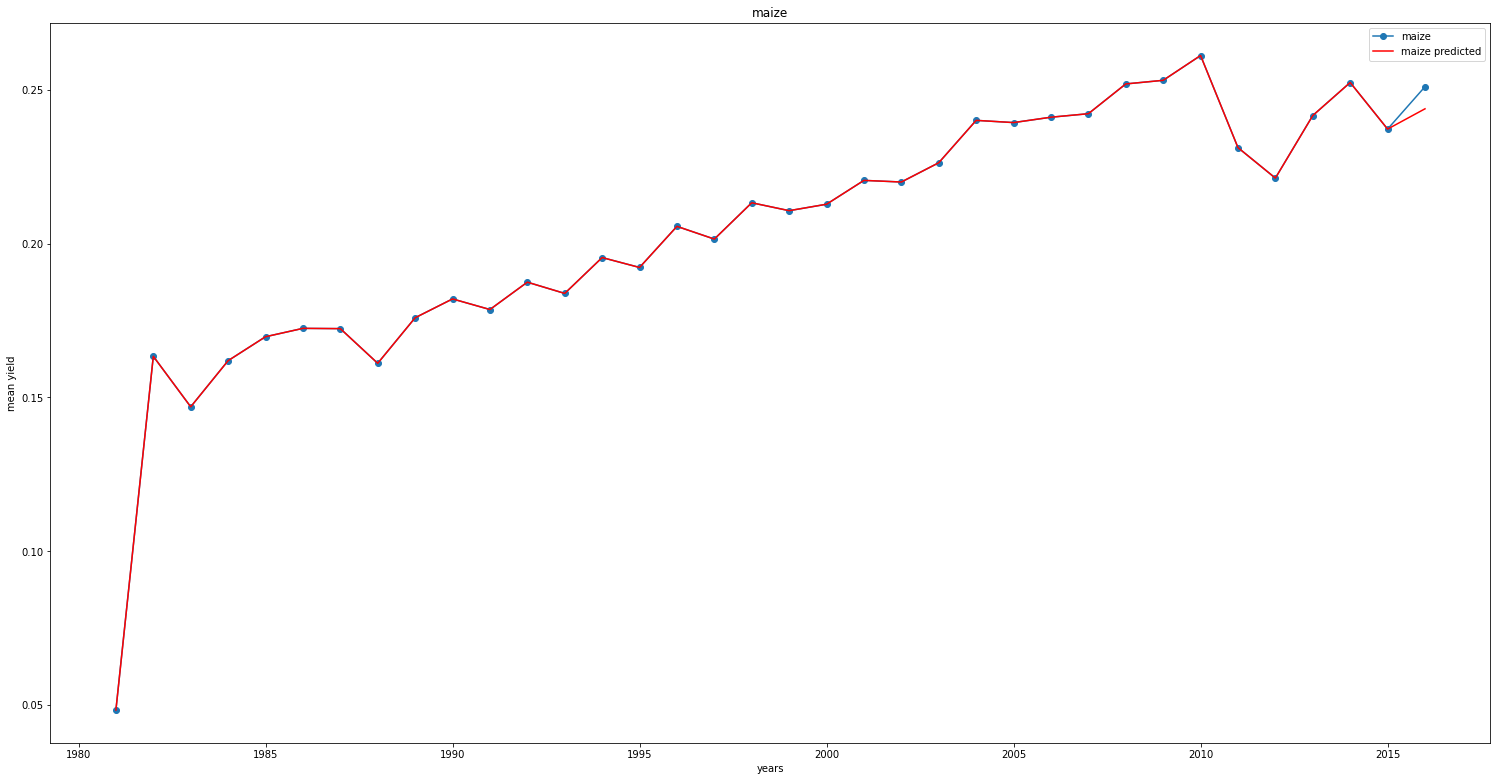

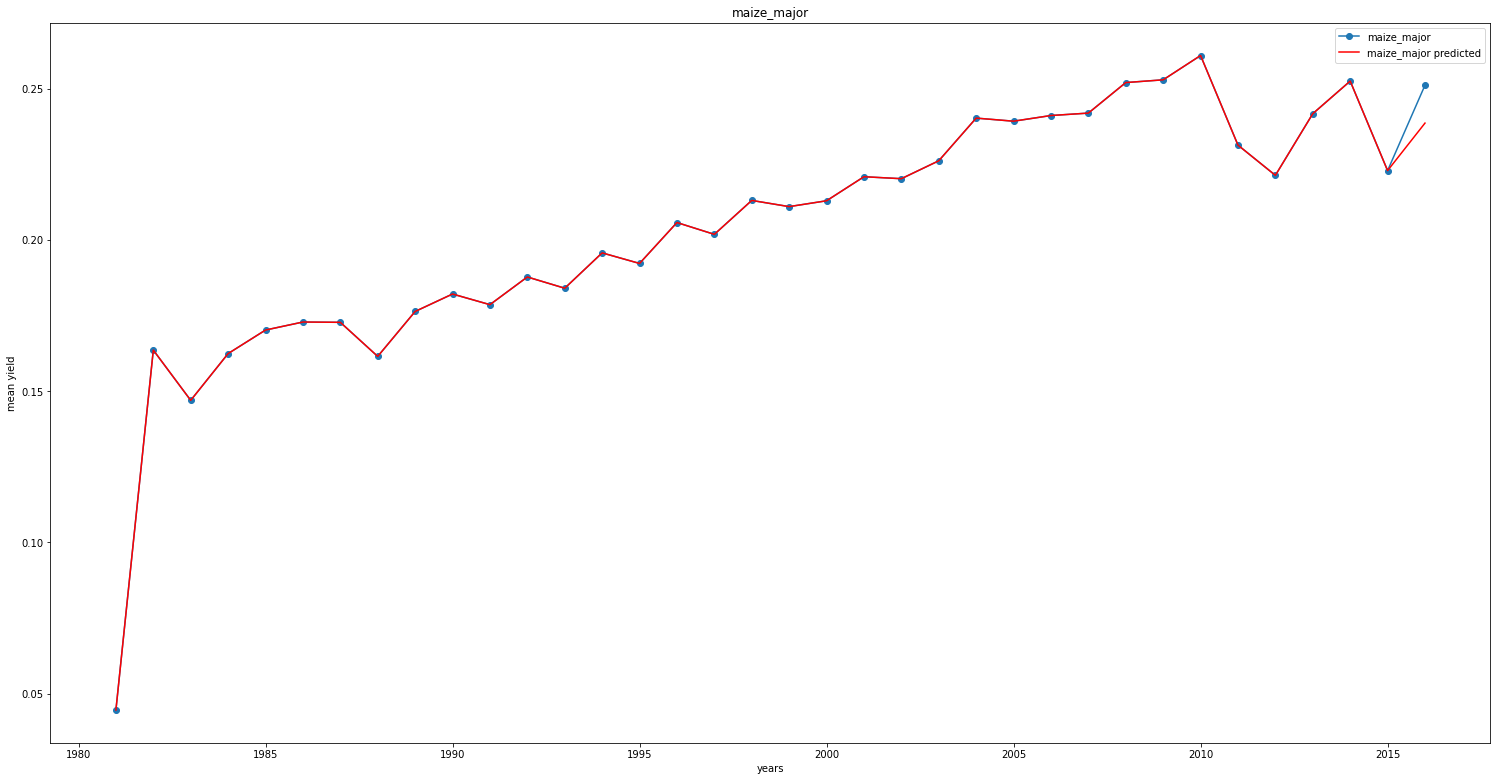

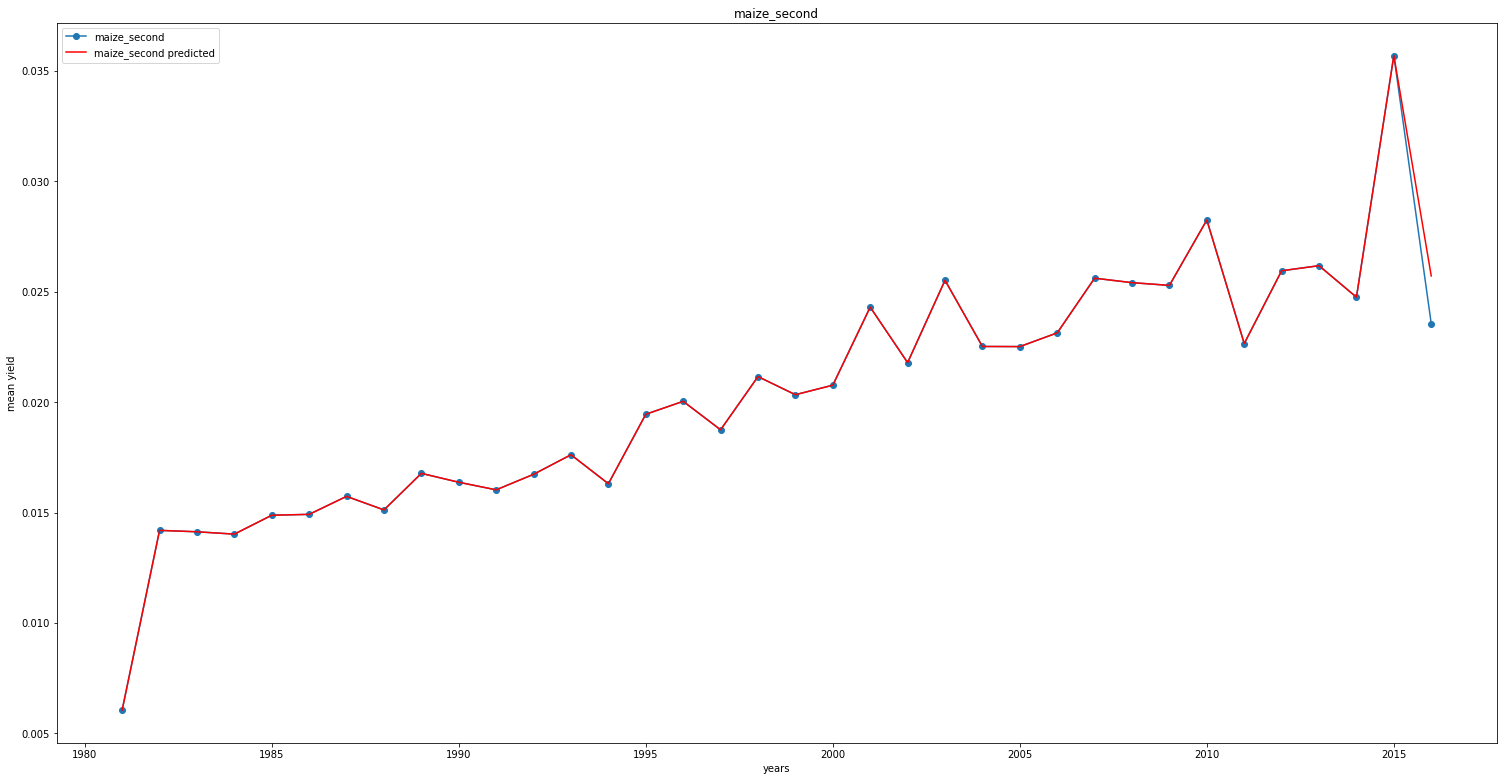

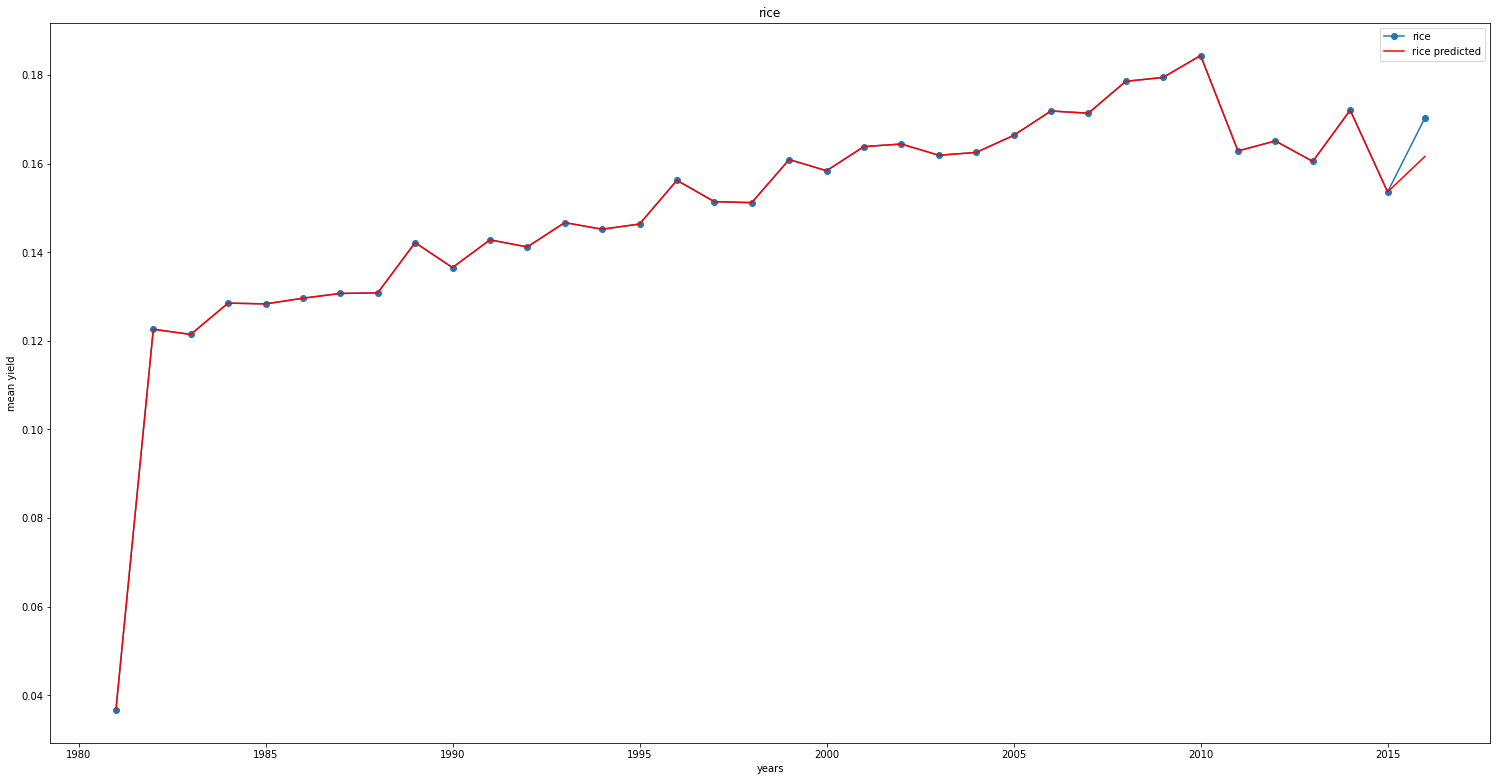

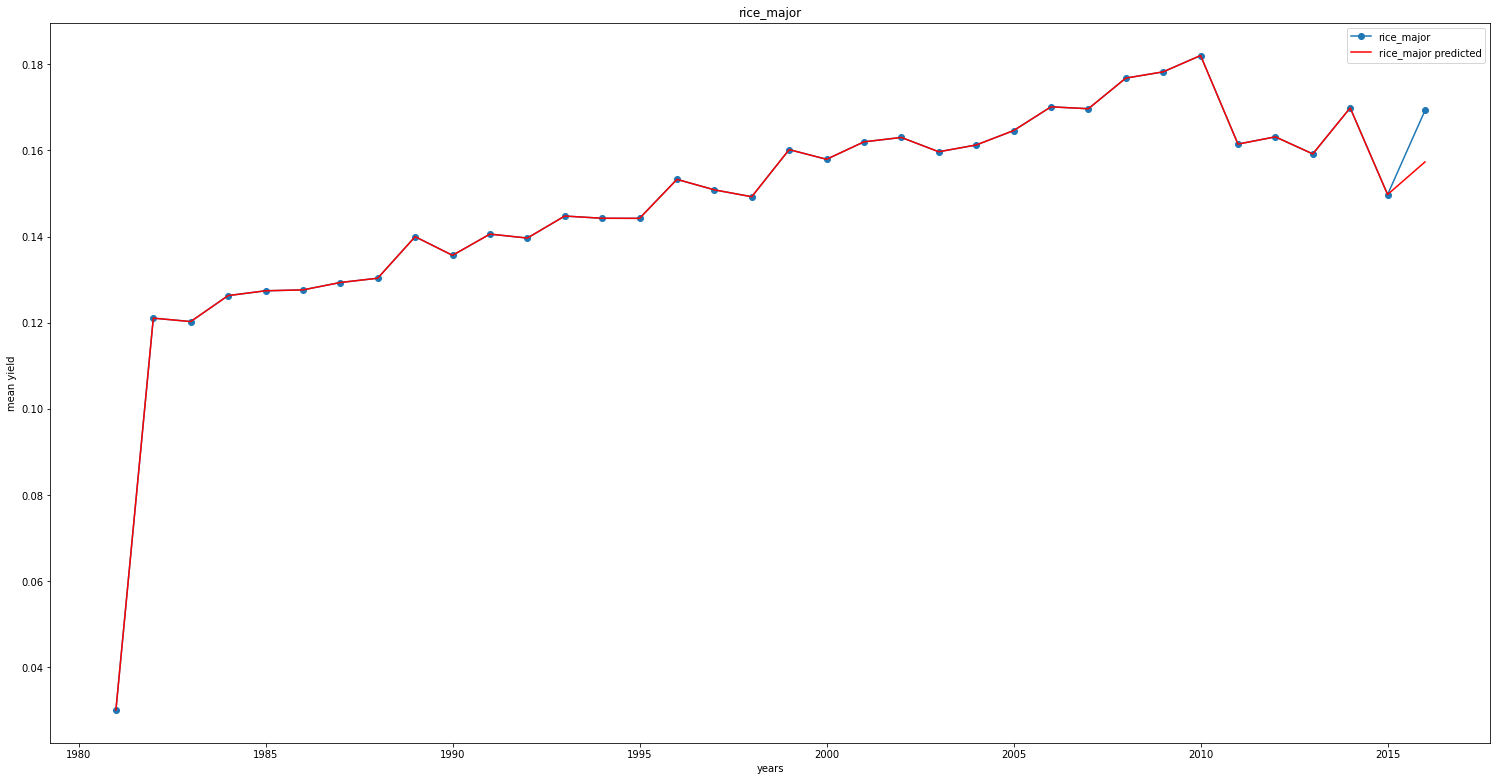

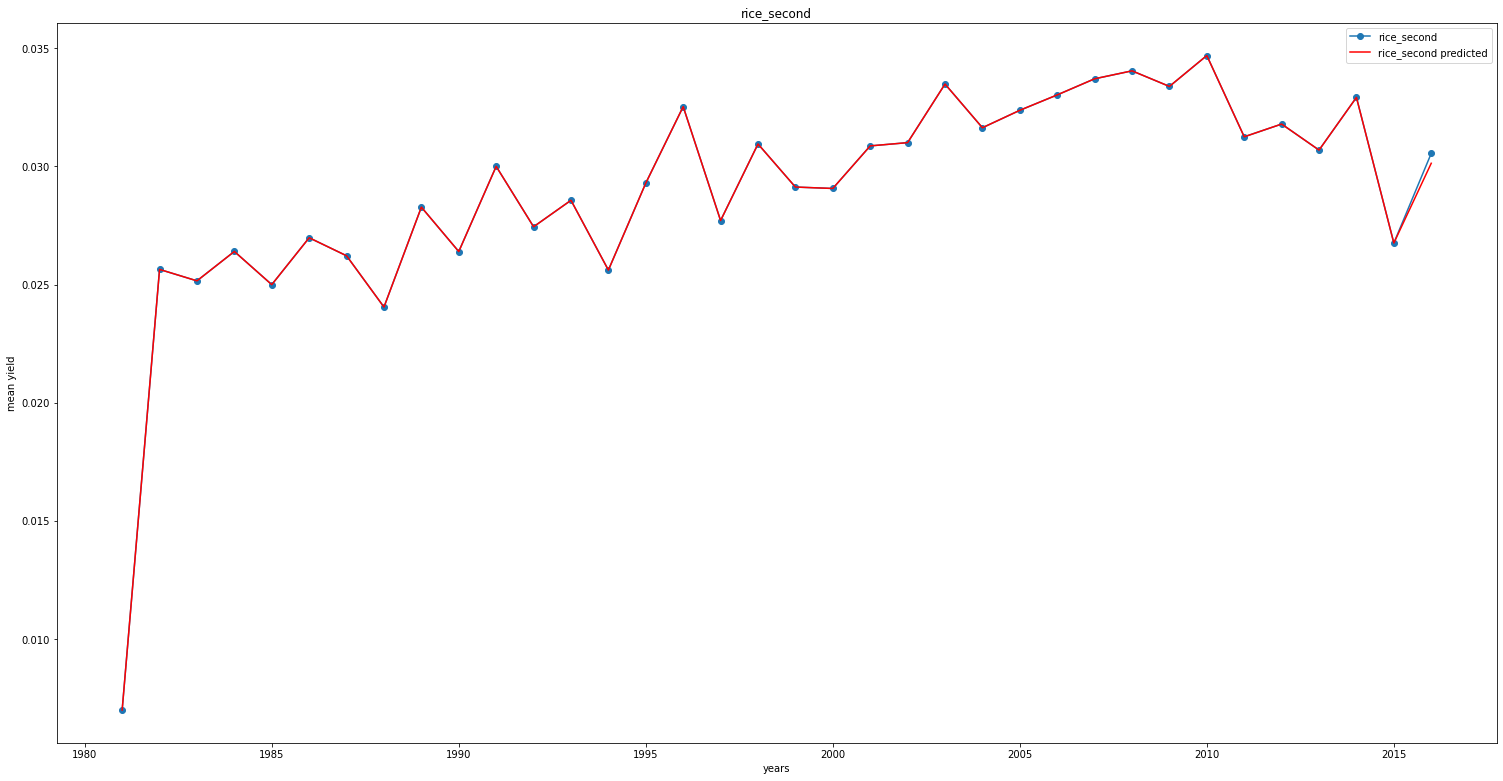

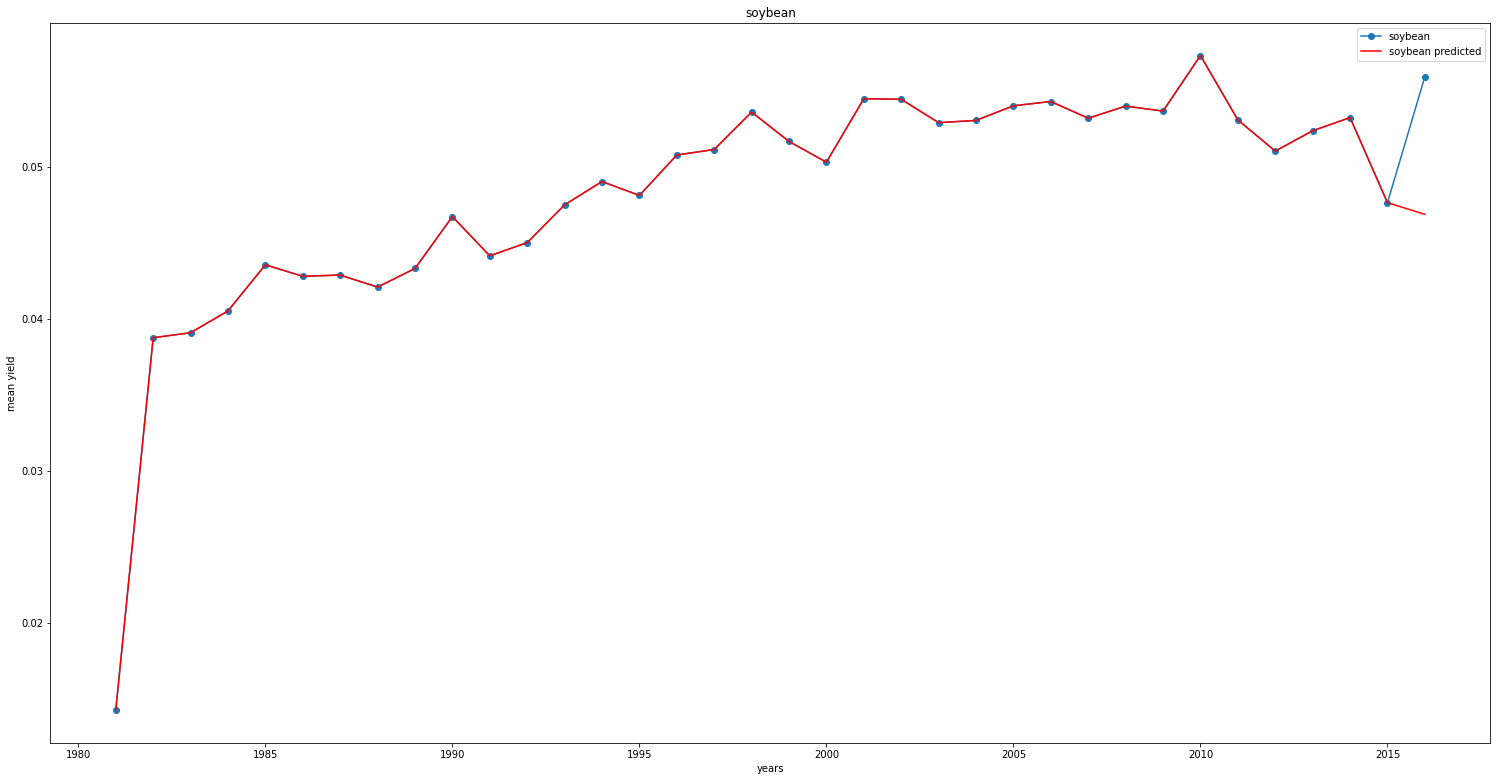

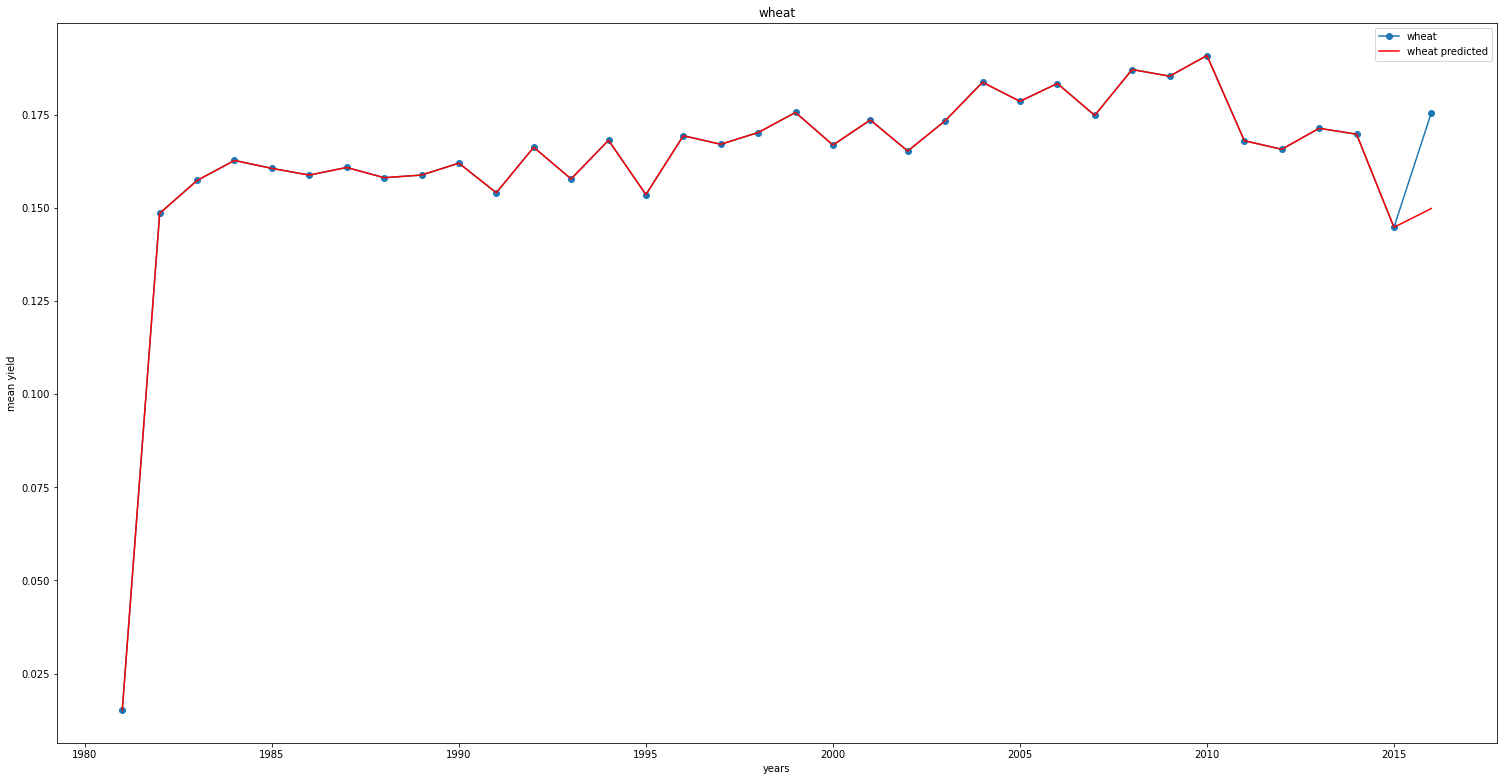

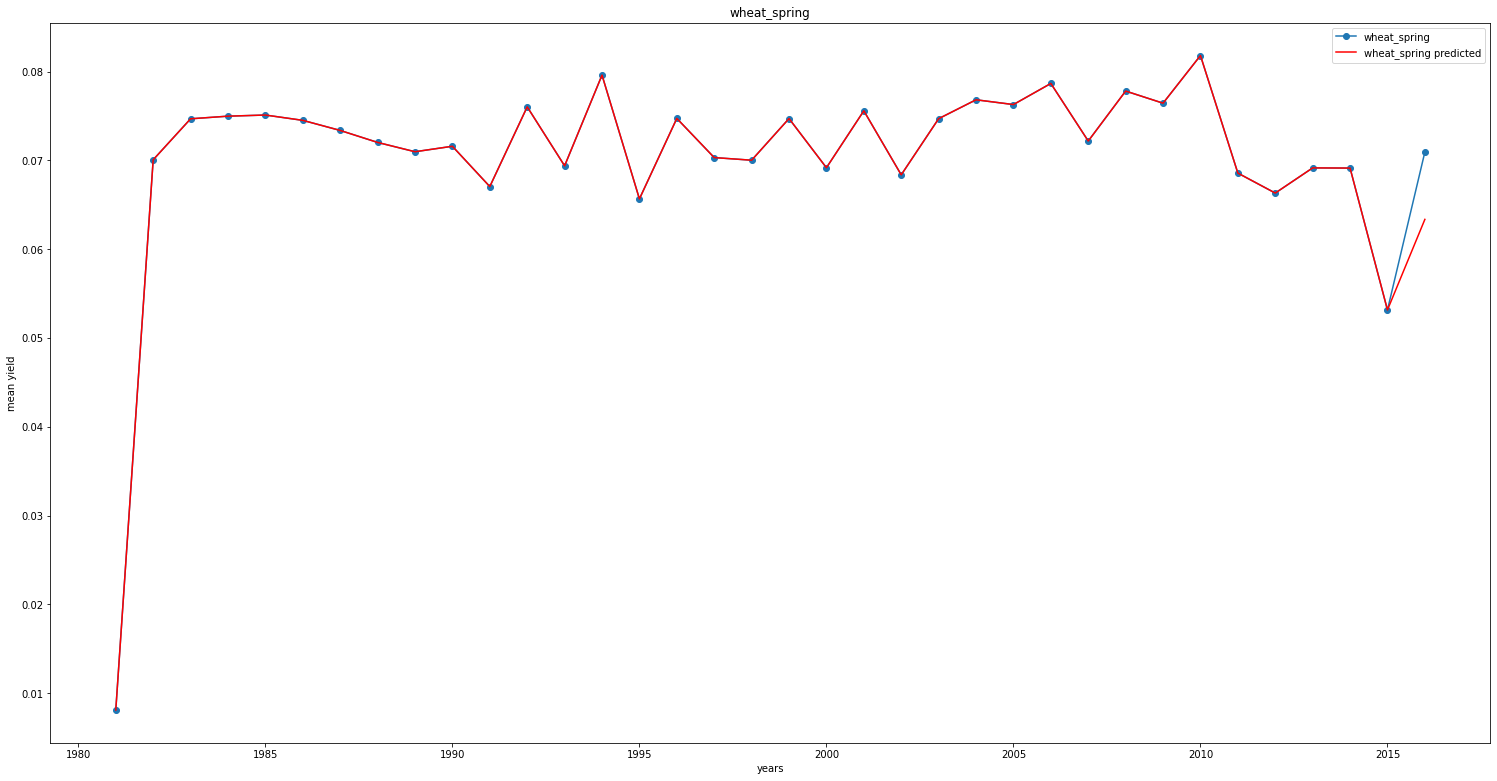

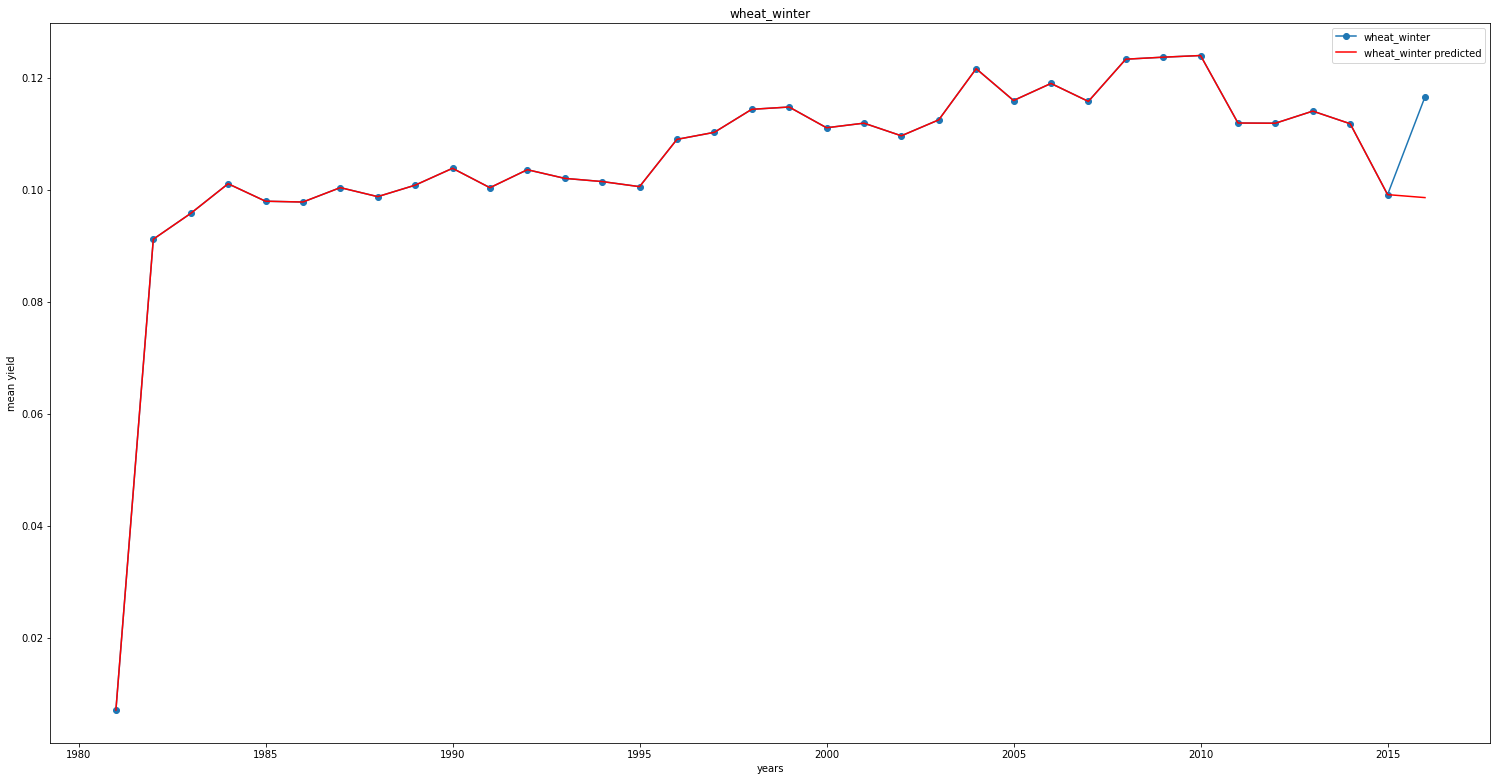

In [11]:
# Predict average map value for the latest year based on all previous years

year = 2016

n_predict = year - max(df['time']) - 1

for c in df['cereal'].unique():
    series = np.array(df_by_cereal.get_group(c)['yield_mean'])
    
    if year > max(df['time']):
        model = ARIMA(series, order=(2,0,1))
        predicted_value = model.fit().forecast()
        series_predicted = list(series.copy())
        series_predicted += list(predicted_value)     
        time = list(df['time'].unique())
        time.append(year)
    else:
        model = ARIMA(series[:n_predict], order=(2,0,1))
        predicted_value = model.fit().forecast()
        series_predicted = series.copy()
        series_predicted[n_predict:] = predicted_value
        time = list(df['time'].unique())

    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_axes([0,0,1,1])
    
    ax.set_xlabel('years')
    ax.set_ylabel('mean yield')
    ax.set_title('Evolution of mean cereal yield averaged over all the cereal along time')
    ax.set_title(c)
    ax.plot(time[:len(series)], series, 'o-')
    ax.plot(time, series_predicted, 'r')
    ax.legend([c, c+' predicted', ])

